# Predecir Skill en LinkedIN

Para esta sección se trabaja con un dataset que consta de las habilidades/capacidades/competencias (skill) declaradas por distintos usuarios en el sitio web LinkedIN, trabajando con una matriz dispersa (<i>sparse matrix</i>) debido a la gran cantidad de valores nulos (competencias no declaradas), esto agiliza los procesos de ajustar el modelo de cada clasificador.

In [2]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from scipy.io import mmread

def cargar_archivo(arch):
    f = open(arch,'r')
    lines= f.readlines()
    M = [ line.replace(":",',').replace("\n","").split(',') for line in lines]
    
    lista_sparse = []
    for usuario in M:
        user_id = usuario.pop(0)
        for skill in usuario:
            lista_sparse.append([int(user_id),int(skill),1])
            
    rows,cols,data = zip(*lista_sparse)
    return csr_matrix((data, (rows, cols)))

import re,codecs
def cargar_skills(arch,d):
    skills = ['None' for i in range(d)]  
    f = codecs.open(arch,'r',encoding="utf-8")
    lines= f.readlines()
    M = [ re.split(':(\d+)',line.strip('\n')) for line in lines]
    for datos_skill in M:
        skills[int(datos_skill[1])] = datos_skill[0]
    return skills

dt_userskill = cargar_archivo('user_skill')
n ,d = dt_userskill.shape 
lista_skills =  cargar_skills('skill_id',d)
#print lista_skills
print dt_userskill.shape

(7890, 14544)


En el código anterior se carga el archivo donde estan presentes los datos y se convierten en una matriz $sparse$ (dispersa), en la cual las filas representan a los usuarios y las columnas a las <i>skill</i> de cada usuario correspondiente, llenando los valores de la matriz con 0 o 1, si declara o no competencia. Por ejemplo si el usuario $i$ declara la competencia $j$ habrá un 1 en la posición ($i$,$j$) en la matriz <i>dt_userskill</i>

In [4]:
n = 7890 #number of users
d = 14544 #number of skills

#from random import randint
#print randint(10,50) #porciento de test set = 34 %
index = np.arange(np.shape(dt_userskill)[0]) #filas 
np.random.shuffle(index) #permutan las filas
Z = dt_userskill[index, :] #matriz permutada

l =  int(7890*.34)
Z_tr = Z[:l,] #Datos de entrenamiento (76%)
Z_ts = Z[l:,] #Datos de prueba (34%)

En la celda anterior se crean, a partir del dataset original <i>Z</i>, dos dataset, uno de prueba y otro de entrenamiento ($Z_{ts}$ y $Z_{tr}$ respectivamente).

In [10]:
users_skill = np.zeros(d) #numero de usuarios por skill
for i in range(d): #every skill
    users_skill[i] = dt_userskill.getcol(i).getnnz()

print users_skill

[  1.59400000e+03   2.10900000e+03   8.00000000e+01 ...,   1.00000000e+00
   1.00000000e+00   1.00000000e+00]


In [ ]:
mejores = [] #cantidad de usuarios de los mejores skill
id_mejores = [] #id de skill de las mejores
peores = []
id_peores = []

mayor_a = []
id_mayor_a = []
for i in range(d):
    if users_skill[i] > 1000:
        mejores.append(users_skill[i])
        id_mejores.append(i)
    if 1000 > users_skill[i] > 300:
        mayor_a.append(users_skill[i])
        id_mayor_a.append(i)
    if users_skill[i] < 5:
        peores.append(users_skill[i])
        id_peores.append(i)

print len(mayor_a)

print "------------Mejores------------------"
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(14,4))
ax.bar(range(len(mejores)),mejores)
ax.set_xticks(np.arange(0.5,len(mejores),1))
ax.set_xticklabels(map(lista_skills.__getitem__, id_mejores), rotation=85)
ax.set_ylabel("cantidad de usuarios")
plt.autoscale(enable=True, axis='x', tight=True)
plt.show()

print "------------Peores------------------"
fig, ax = plt.subplots(figsize=(14,4))
ax.bar(range(len(peores)),peores)
ax.set_xticks(np.arange(0.5,len(peores),1))
ax.set_xticklabels(map(lista_skills.__getitem__, id_peores), rotation=85)
ax.set_ylabel("cantidad de usuarios")
plt.autoscale(enable=True, axis='x', tight=True)
#plt.show()

fig, ax = plt.subplots(figsize=(9,10))
ax.barh(range(len(mayor_a)),mayor_a)
ax.set_yticks(np.arange(0.5,len(mayor_a),1))
ax.set_yticklabels(map(lista_skills.__getitem__, id_mayor_a))
ax.set_xlabel("cantidad de usuarios")
plt.autoscale(enable=True, axis='y', tight=True)
plt.show()

52
------------Mejores------------------


/usr/lib/python2.7/dist-packages/matplotlib/backends/backend_gtk.py:253: Warning: Source ID 1612 was not found when attempting to remove it
  gobject.source_remove(self._idle_event_id)


------------Peores------------------


se genera una lista con la cantidad de usuarios por cada $skill$

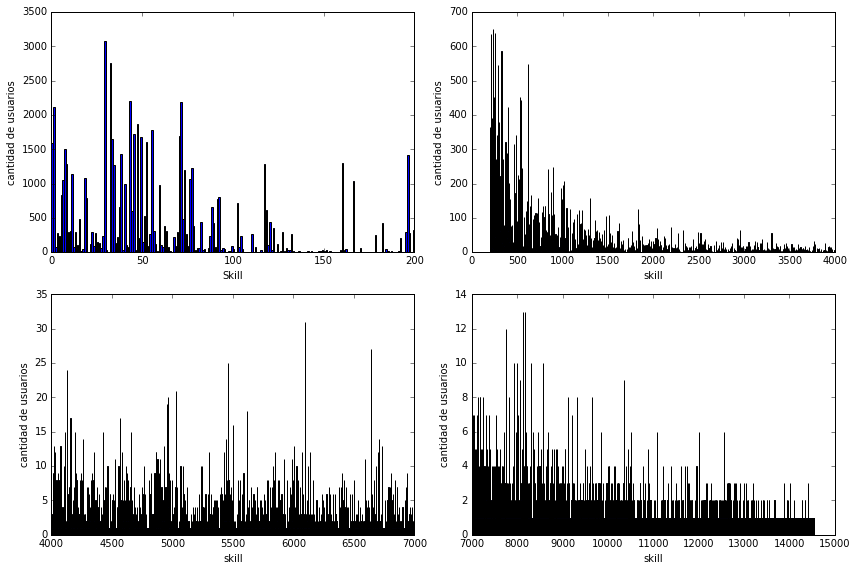

In [40]:
####GRAFICOS-----------------
import matplotlib.pyplot as plt

f, axarr = plt.subplots(2, 2, figsize=(12, 8))
axarr[0, 0].bar(range(200),users_skill[:200])
axarr[0, 0].set_xlabel('Skill')
axarr[0, 0].set_ylabel('cantidad de usuarios')
axarr[0, 0].legend()

axarr[0, 1].bar(range(200,4000),users_skill[200:4000])
axarr[0, 1].set_xlabel('skill')
axarr[0, 1].set_ylabel('cantidad de usuarios')
axarr[0, 1].legend()

axarr[1, 0].bar(range(4000,7000),users_skill[4000:7000])
axarr[1, 0].set_xlabel('skill')
axarr[1, 0].set_ylabel('cantidad de usuarios')
axarr[1, 0].legend(frameon=True)

axarr[1, 1].bar(range(7000,d),users_skill[7000:d])
axarr[1, 1].set_xlabel('skill')
axarr[1, 1].set_ylabel('cantidad de usuarios')
axarr[1, 1].legend(loc='upper right', fancybox=True)

f.tight_layout() #separar los subplot
plt.show()

En los gráficos anteriores se visualiza la cantidad de usuarios que declara cada competencia (skill),

In [29]:
j = 0 # columna a predecir
print "competencia a predecir: %s"%(lista_skills[j])
cols = range(d) #lista de columnas
cols.remove(j)

y_tr = Z_tr.getcol(j).toarray().T[0] #target training set
y_ts = Z_ts.getcol(j).toarray().T[0] #target test set

from scipy import sparse
X_tr = sparse.lil_matrix(sparse.csr_matrix(Z_tr)[:,cols])
X_ts = sparse.lil_matrix(sparse.csr_matrix(Z_ts)[:,cols])
print "matrices formadas"

competencia a predecir: Business Intelligence 
matrices formadas


In [30]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

def score_the_model(model,x,y,xt,yt,text):
    acc_tr = model.score(x,y)
    acc_test = model.score(xt[:-1],yt[:-1])
    print "El modelo: %s se ha ajustado"%(text)
    return [acc_tr,acc_test]

def clasificar_prob(y,yt):
    #AJUSTE
    frecuencia =  np.bincount(y) 
    etiquetas = list(set(y))
    total = float(sum(frecuencia))
    prob = [i/total for i in frecuencia]
    #PREDICT
    np.random.seed(0)
    yhat = [ np.random.choice(etiquetas,p=prob) for i in range(len(y)) ]
    yhat_t = [ np.random.choice(etiquetas,p=prob) for i in range(len(y)) ]
    #SCORE
    acc_tr = [ 1 if(i == j) else 0  for i,j in zip(yhat,y)]
    acc_ts = [ 1 if(i == j) else 0  for i,j in zip(yhat_t,yt)]
    return [ np.mean(acc_tr), np.mean(acc_ts) ] 

names = ["Naive Bayes","Multinomial","Logistico","SVM","k-NN","Arboles"]
classifiers = [
    BernoulliNB(),
    MultinomialNB(),
    LogisticRegression(penalty='l2',C=1),
    LinearSVC(C=0.1),
    KNeighborsClassifier(n_neighbors=10),
    DecisionTreeClassifier(max_features = 'log2')
]
def make_classification(x,y,xt,yt):
    accuracys = []
    for model,name in zip(classifiers,names):
        if name == "Arboles":
            x  = x.todense()
            xt = xt.todense()
        model.fit(x, y)
        accuracys += score_the_model(model,x,y,xt,yt,name)
    #clasificador a priori
    accuracys += clasificar_prob(y,yt)
    return accuracys
    
scores = make_classification(X_tr,y_tr,X_ts,y_ts)
print scores

El modelo: Naive Bayes se ha ajustado
El modelo: Multinomial se ha ajustado
El modelo: Logistico se ha ajustado
El modelo: SVM se ha ajustado
El modelo: k-NN se ha ajustado
El modelo: Arboles se ha ajustado
[0.86241610738255037, 0.83445362012675239, 0.87472035794183445, 0.82120222777030916, 0.96718866517524238, 0.88592279623583636, 0.97129008202833711, 0.88438640291914727, 0.81282624906785983, 0.81947378528903403, 1.0, 0.79124255809487232, 0.65846383296047728, 0.69388516032811332]


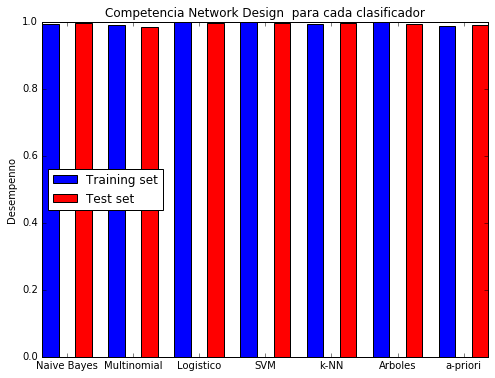

In [45]:
####GRAFICOS-----------------
import matplotlib.pyplot as plt

def graficar_scores(scores,comp):
    title = "Competencia "+ comp + " para cada clasificador"
    colors = ['b','r']*7
    fig, ax = plt.subplots(figsize=(8,6))
    
    barlist = ax.bar(range(0,14), scores, width  = 0.5, align = "center", color = colors)
    ax.set_ylabel('Desempenno')
    ax.set_title(title)
    ax.set_xticks([0.5,2.5,4.5,6.5,8.5,10.5,12.5])
    ax.set_xticklabels(names+["a-priori"])
    ax.legend( barlist,["Training set","Test set"], loc = 'center left')
    plt.autoscale(enable=True, axis='x', tight=True)
    plt.show()
graficar_scores(scores,lista_skills[j])

Competencia que predice: Team Leadership  (1.000000)
El modelo: Naive Bayes se ha ajustado
El modelo: Multinomial se ha ajustado
El modelo: Logistico se ha ajustado
El modelo: SVM se ha ajustado
El modelo: k-NN se ha ajustado
El modelo: Arboles se ha ajustado
[0.8530947054436987, 0.816593047820242, 0.85682326621923932, 0.79335509890531974, 0.97203579418344521, 0.84847320914154023, 0.97427293064876952, 0.84501632417898986, 0.78709917971662935, 0.79009026310735553, 1.0, 0.72959477626272329, 0.59545115585384045, 0.62043251304996272]


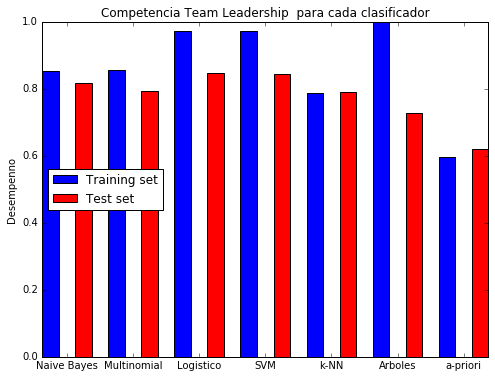

Competencia que predice: Microsoft Office  (29.000000)
El modelo: Naive Bayes se ha ajustado
El modelo: Multinomial se ha ajustado
El modelo: Logistico se ha ajustado
El modelo: SVM se ha ajustado
El modelo: k-NN se ha ajustado
El modelo: Arboles se ha ajustado
[0.85458612975391501, 0.77376608411753411, 0.86316181953765847, 0.7741501824467063, 0.96308724832214765, 0.81256001536393319, 0.96532438478747207, 0.80795083541386592, 0.82997762863534674, 0.7749183791050509, 0.99962714392244589, 0.7030919915498367, 0.52721849366144669, 0.53840417598806856]


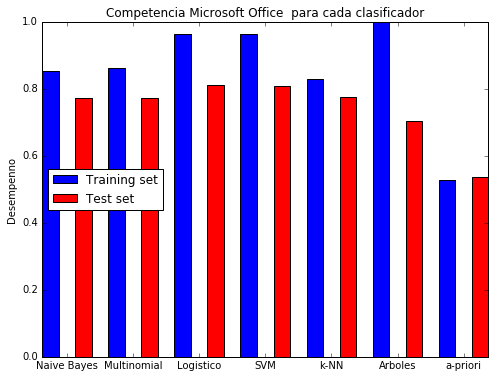

Competencia que predice: Spanish  (40.000000)


In [ ]:
from scipy import sparse

competencias = [1,29,40,340,500,900] # columna a predecir (> 1000 produce errores con logistic)

for j in competencias:
    print "Competencia que predice: %s (%f)"%(lista_skills[j],j)
    cols = range(d) #lista de columnas
    cols.remove(j)

    y_tr = Z_tr.getcol(j).toarray().T[0] #target training set
    y_ts = Z_ts.getcol(j).toarray().T[0] #target test set

    X_tr = sparse.lil_matrix(sparse.csr_matrix(Z_tr)[:,cols])
    X_ts = sparse.lil_matrix(sparse.csr_matrix(Z_ts)[:,cols])
    
    scores = make_classification(X_tr,y_tr,X_ts,y_ts)
    print scores
    
    graficar_scores(scores, lista_skills[j])
    
    #if j == 340:
    #    break